In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, create_gif, clear_temp
from modules.problems import diffusion
from modules.training import train

import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled):
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values.detach().numpy()]
            return values
    
    t = torch.linspace(0, problem.T, problem.Nt)
    x = torch.linspace(problem.L, problem.R, problem.Nx)
    problem.left_values =  problem.left_boundary [nearest_index(t, t_left_sampled) ].to(device)
    problem.right_values = problem.right_boundary[nearest_index(t, t_right_sampled)].to(device)
    problem.init_values =  problem.initial_values[nearest_index(x, x_sampled)      ].to(device)

def grid_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    x_sampled = torch.linspace(problem.L, problem.R, N_I, requires_grad=True)
    t_left_sampled =  torch.linspace(0, problem.T, N_L, requires_grad=True)
    t_right_sampled = torch.linspace(0, problem.T, N_R, requires_grad=True)
    
    k = np.sqrt(problem.Nt * problem.Nx / N_F)
    nt, nx = int(problem.Nt / k), int(problem.Nx / k)
    x_pts, t_pts = [
        pts.reshape(-1, 1) for pts in torch.meshgrid(
        torch.linspace(problem.L, problem.R, nx, requires_grad=True).to(device),
        torch.linspace(0, problem.T, nt, requires_grad=True).to(device),
        indexing='ij'
    )]
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
        
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

def random_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch. float32, requires_grad=True)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_L), dtype=torch.float32, requires_grad=True)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_R), dtype=torch.float32, requires_grad=True)
    
    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_F), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_F), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
    
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

In [3]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self, alpha=1, learnable=False):
        super(SinActivation, self).__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.as_tensor(alpha))
        else:
            self.alpha = alpha
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta=1, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [18]:
problem_number = 2
problem = diffusion.Diffusion.get_problem(problem_number)

L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1, activation=nn.Tanh())
name = f'diff{problem_number}_tanh'

num_iters = 10000
plot_every = 250

coef = 0.75
result = train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {"lr": 1e-3},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 10000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {
                'N_I': 128,
                'N_L': 128,
                'N_R': 128,
                'N_F': 2048
                },
            'generation_function': grid_sample
        },
        'coefs': [[coef, coef, coef], [1 - coef]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    logging_params={
        'loss':  100,
        'norms': 100,
        'error': 100,
        'steps': 100,
        'log_dir': None
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 5)
    },
    name=name,
    print_every=num_iters + 1
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/diff/{name}_test.gif'
)

KeyboardInterrupt: 

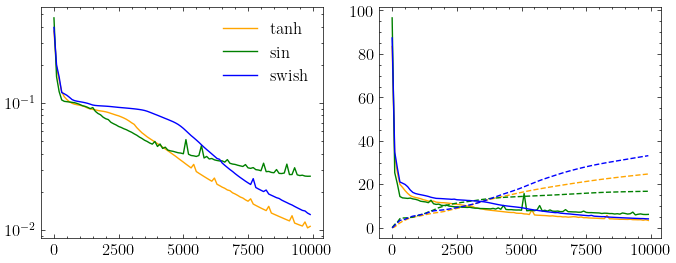

In [14]:
import json
files = ['./logging/diff1.json', './logging/diff1_sin.json', './logging/diff1_swish.json']
colors = ['orange', 'green', 'blue']

fig, ax = plt.subplots(1, 2, figsize=(8, 3), width_ratios=[1, 1])

iters = np.arange(0, num_iters, 100)
for i, activ in enumerate(['tanh', 'sin', 'swish']):
    with open(files[i], 'r') as file:
        log = json.load(file)

    loss_history = []
    error_history = []
    step_history = []
    for j in range(0, num_iters, 100):
        loss_history.append( log[str(j)]['loss'])
        error_history.append(log[str(j)]['error'])
        step_history.append( log[str(j)]['step'])
        
    loss_history =  np.array(loss_history )
    error_history = np.array(error_history)
    step_history =  np.array(step_history )
    
    ax[0].plot(iters, loss_history[:, 2], label=activ, color=colors[i])
    
    ax[1].plot(iters, error_history, label=activ, color=colors[i])
    ax[1].plot(iters, step_history, label=activ, linestyle='dashed', color=colors[i])

ax[0].legend()
ax[0].set_yscale('log')
# ax[1].set_yscale('log')

plt.show()

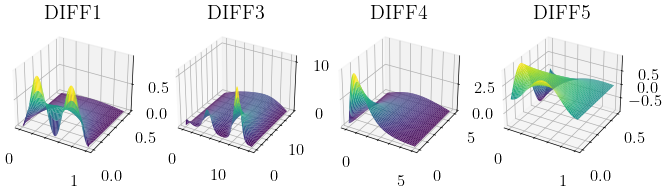

In [39]:
inds = [1, 3, 4, 5]
problems = [Diffusion.get_problem(i) for i in inds]
indexes = [141, 142, 143, 144]

size = (6.7, 1.8)
fig = plt.figure(figsize=size)

for i, index, problem in zip(inds, indexes, problems):
    X, T = np.meshgrid(problem.x, problem.t)
    ax = fig.add_subplot(index, projection='3d')
    ax.plot_surface(X, T, problem.solution, cmap='viridis')
    ax.title.set_text(f'DIFF{i}')
plt.tight_layout()

plt.savefig('../images/diff_grid.png', dpi=250)
plt.show()